# Residual Analysis

## 1. ML Model

In [75]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from loguru import logger
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
from blog.data.data_cleaner_factory import DataCleanerFactory
from blog.model.regularisation import select_features, get_monotone_constraints
from blog.model.optimise import ROCAUCObjective, MultiObjective, PRAUCObjective
from blog.model.evaluation import show_model_results
from probatus.interpret import ShapModelInterpreter
from blog.data.lendingclub_dataset import LendingClubDataset
from blog.model.sampling import oot_split
from blog.model.regularisation import get_monotone_constraints
from blog.model.feature_transformations import get_simple_feature_transformation
from blog.model.optimise import getObjective, tune_model
from blog.model.evaluation import get_segment_rocauc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset_name = "lendingclub"
target = "loan_status"
path = "../data/lc_2007_2017.csv"

initial_features = [
    "verification_status",
    "emp_title",
    "int_rate",
    "loan_amnt",
    "total_rec_int",
    "total_acc",
    "tot_cur_bal",
    "fico_range_low",
    "fico_range_high",
    "grade",
    "total_rev_hi_lim",
    "sub_grade",
    "initial_list_status",
    "purpose",
    "issue_d",
    "emp_length",
    "pub_rec_bankruptcies",
    "last_pymnt_amnt",
    "num_actv_bc_tl",
    "total_pymnt",
    "loan_status",
    "term",
    "home_ownership",
    "revol_util",
    "application_type",
    "addr_state",
    "inq_last_6mths",
    "pub_rec",
    "dti",
    "mort_acc",
    "revol_bal",
    "title",
    "annual_inc",
    "out_prncp",
    "open_acc",
    "installment",
    "home_ownership",
    "avg_cur_bal",
    "annual_inc",
    "num_tl_90g_dpd_24m"
]

# combine two lists without duplicates
initial_features = list(set(initial_features))
print(initial_features)
# ================== Read and clean the dataset.===========================================
logger.info(f"1.Read data")
lcd = LendingClubDataset()
X, y = lcd.get_data(path=path, use_cols=initial_features, dropna=False, sample=-1)
logger.info(f"\nTarget distribution:\n{y.value_counts(normalize=True)}")

# Split data into IT & OOT datasets.
data = X.copy()
data[target] = y

X_it, y_it, X_oot, y_oot = oot_split(
    df=data, split_date="Jun-2016", split_col="issue_d", target_col=target
)
# Original data dictionary
data_dict = {"xtrain": X_it, "ytrain": y_it, "xtest": X_oot, "ytest": y_oot}

# =================== Apply feature transformation =========================================
logger.info(f"2.Transform features")
#data_dict = get_simple_feature_transformation(data_dict_org)

# =================== Feature Selection =========================================
logger.info(f"3.Starting feature selection.")
# Select the best features based on SHAPRFE CV
# selected_features, fs_plot = select_features(data=data_dict, verbose=100)

# selected_features=['loan_amnt','int_rate','installment','grade','annual_inc','home_ownership',
#                    'emp_length','term','addr_state', 
#                    'fico_range_low', 'fico_range_high']

selected_features = [
    "emp_length",
    "addr_state",
    "revol_util",
    "revol_bal",
    "term",
    "num_actv_bc_tl",
    "total_acc",
    "application_type",
    "purpose",
    "grade",
    'dti',
    "home_ownership",
    "annual_inc",
    "num_tl_90g_dpd_24m"
]
logger.info(f"Final features :  {selected_features}")
# Update the data dictionary with the selected features.
data_dict["xtrain"] = data_dict["xtrain"][selected_features]
data_dict["xtest"] = data_dict["xtest"][selected_features]


# model_params = tune_model(data_dict["xtrain"], data_dict["ytrain"], "rocauc")

model_params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "feature_pre_filter": False,
    "lambda_l1": 3.221919143923753e-08,
    "lambda_l2": 0.0016740960905730054,
    "num_leaves": 66,
    "feature_fraction": 0.6,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "min_child_samples": 20,
}

# model_params =  {
# 'n_estimators': 600,
# 'objective': 'binary',
# 'seed': 41114,
# 'n_jobs': 8,
# 'metric': 'auc',
# 'num_leaves': 40,
# 'bagging_fraction': 1,
# 'max_bin': 70,
# 'learning_rate': 0.05,
# 'reg_alpha': 0,
# 'reg_lambda': 0,
# 'min_child_weight': 1e-2,
# 'min_child_samples': 10,
# 'max_depth': 12
# }


# =================== Train Model =========================================
logger.info(f"5.Train Model ")
logger.info(f"Creating model with params : {model_params}")
mono_lgb = lgb.LGBMClassifier(**model_params)
mono_model = show_model_results(data=data_dict, model=mono_lgb)

2022-04-13 22:26:53.349 | INFO     | __main__:<module>:52 - 1.Read data
2022-04-13 22:26:53.350 | INFO     | blog.data.lendingclub_dataset:_read_data:24 - Reading data from path ../data/lc_2007_2017.csv


['out_prncp', 'loan_status', 'emp_length', 'term', 'application_type', 'pub_rec_bankruptcies', 'int_rate', 'avg_cur_bal', 'addr_state', 'issue_d', 'home_ownership', 'open_acc', 'inq_last_6mths', 'installment', 'total_rec_int', 'initial_list_status', 'revol_util', 'revol_bal', 'pub_rec', 'tot_cur_bal', 'num_tl_90g_dpd_24m', 'sub_grade', 'total_rev_hi_lim', 'dti', 'mort_acc', 'verification_status', 'total_acc', 'fico_range_high', 'annual_inc', 'num_actv_bc_tl', 'fico_range_low', 'loan_amnt', 'total_pymnt', 'title', 'grade', 'purpose', 'emp_title', 'last_pymnt_amnt']


2022-04-13 22:27:04.754 | INFO     | blog.data.lendingclub_dataset:_read_data:28 - Read data with shape (1646801, 38)
2022-04-13 22:27:06.777 | INFO     | blog.data.lendingclub_dataset:_process_data:73 - Creating target data.
2022-04-13 22:27:11.619 | INFO     | blog.data.lendingclub_dataset:get_data:118 - Shape of training data X :(733201, 39), y : (733201,).
2022-04-13 22:27:11.882 | INFO     | __main__:<module>:55 - 
Target distribution:
0    0.788508
1    0.211492
Name: loan_status, dtype: float64
2022-04-13 22:27:12.347 | INFO     | blog.model.sampling:oot_split:63 - IT data info 
 : {'name': 'IT', 'X_shape': (641029, 40), 'y_shape': (641029,), 'default_rate': 21.58233090858604, 'pct_of_data': 87.4, 'earliest_disbursed_date': Timestamp('2012-08-01 00:00:00'), 'latest_disbursed_date': Timestamp('2016-05-01 00:00:00'), 'default_count': 138349}
2022-04-13 22:27:12.348 | INFO     | blog.model.sampling:oot_split:64 - OOT data info 
 : {'name': 'OOT', 'X_shape': (92172, 40), 'y_shape': 

[LightGBM] [Warning] lambda_l1 is set=3.221919143923753e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.221919143923753e-08
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0016740960905730054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016740960905730054
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=3.221919143923753e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.221919143923753e-08
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fract

## Error Analysis

In [3]:
# Create a validation set, to do the error analysis.
X_train, X_val, y_train, y_val = train_test_split(data_dict["xtrain"], data_dict["ytrain"], test_size=0.2,stratify=data_dict["ytrain"])

In [4]:
# Train the model
lgb_model = lgb.LGBMClassifier(**model_params)
lgb_model.fit(X_train,y_train)

yhat_name = 'p_loan_status'
preds1 = lgb_model.predict_proba(X_val)[:,1]

X_val_results = X_val.copy().reset_index(drop=True)
X_val_results[yhat_name] = preds1
X_val_results[target] = y_val.values

X_val_results.head()

[LightGBM] [Warning] lambda_l1 is set=3.221919143923753e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.221919143923753e-08
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0016740960905730054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016740960905730054
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


,emp_length,addr_state,revol_util,revol_bal,term,num_actv_bc_tl,total_acc,application_type,purpose,grade,dti,home_ownership,annual_inc,num_tl_90g_dpd_24m,p_loan_status,loan_status
0,10.0,ca,77.4,67556.0,36 months,4.0,63.0,individual,credit_card,d,22.83,mortgage,119000.0,0.0,0.144184,0
1,10.0,ca,34.4,16289.0,36 months,1.0,22.0,individual,debt_consolidation,b,17.03,mortgage,120000.0,1.0,0.082834,0
2,0.0,tx,26.3,17575.0,36 months,4.0,34.0,individual,debt_consolidation,a,20.51,mortgage,55000.0,0.0,0.058611,0
3,10.0,mi,61.4,6882.0,60 months,6.0,25.0,individual,credit_card,d,17.91,mortgage,42000.0,0.0,0.389567,1
4,10.0,tx,16.2,6012.0,36 months,3.0,21.0,individual,credit_card,c,28.85,rent,45000.0,0.0,0.222262,1


In [5]:
# Calculate the log loss error.
from sklearn.metrics import log_loss
import numpy as np
resid_name = f'r_{target}' 
# calculate logloss residuals
X_val_results[resid_name] = -X_val_results[target]*np.log(X_val_results[yhat_name]) -(1 - X_val_results[target])*np.log(1 - X_val_results[yhat_name])   
# check that logloss is calculated correctly
print('Mean logloss residual: %.6f' % X_val_results[resid_name].mean())
print('Logloss from sklearn %.6f' % log_loss(y_val, preds1))

Mean logloss residual: 0.469852
Logloss from sklearn 0.469852


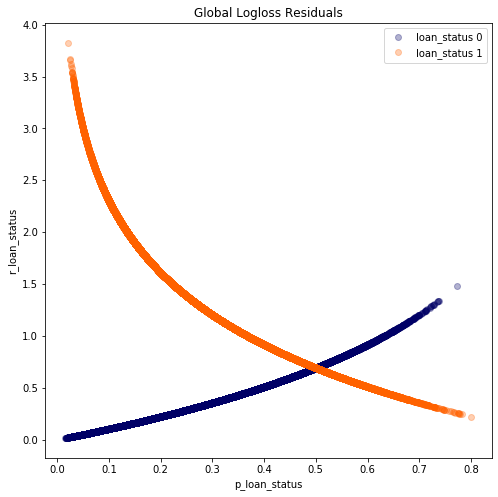

In [6]:
# initialize figure
# Matplotlib figure inline
%matplotlib inline   
fig, ax_ = plt.subplots(figsize=(8, 8))         
valid_yhat_df = X_val_results.copy()
# plot groups with appropriate color
color_list = ['#000066', '#FF6200'] 
c_idx = 0
groups = valid_yhat_df.groupby(target) # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.p_loan_status, group.r_loan_status, 
             label=' '.join([target, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1
    
# annotate plot
plt.xlabel(yhat_name)
plt.ylabel(resid_name)
ax_.legend(loc=1)
plt.title('Global Logloss Residuals')
plt.show()


Some high-magnitude outlying residuals are visible. 
* Who are these customers? 
* Why is the model so wrong about them? 
* And are they somehow exerting undue influence on other predictions? 

The model could be retrained without these individuals and retested as a potentially remediation strategy.

`loan_status = 1 Residuals`

In [7]:
bins = [0, 30, 90, 100]
labels = ['low','medium','high']
valid_yhat_df['dti_binned'] = pd.cut(valid_yhat_df['dti'], bins=bins, labels=labels)

valid_yhat_df1 = valid_yhat_df[valid_yhat_df[target] == 1]
valid_yhat_df1 = valid_yhat_df1.sort_values(by=f'r_{target}', ascending=False).reset_index(drop=True)
valid_yhat_df1.head()

,emp_length,addr_state,revol_util,revol_bal,term,num_actv_bc_tl,total_acc,application_type,purpose,grade,dti,home_ownership,annual_inc,num_tl_90g_dpd_24m,p_loan_status,loan_status,r_loan_status,dti_binned
0,10.0,wa,4.9,1932.0,36 months,1.0,20.0,individual,debt_consolidation,a,14.22,mortgage,200000.0,0.0,0.021816,1,3.825095,low
1,10.0,sc,9.1,5382.0,36 months,3.0,26.0,individual,debt_consolidation,a,9.84,mortgage,114500.0,0.0,0.025609,1,3.664794,low
2,0.0,dc,20.2,29769.0,36 months,1.0,33.0,individual,credit_card,a,11.38,own,170000.0,0.0,0.025644,1,3.663429,low
3,10.0,wa,22.5,24621.0,36 months,7.0,42.0,individual,debt_consolidation,a,5.94,mortgage,150000.0,0.0,0.026638,1,3.625411,low
4,6.0,ca,37.9,11774.0,36 months,2.0,23.0,individual,debt_consolidation,a,3.52,mortgage,200000.0,0.0,0.027230,1,3.603430,low


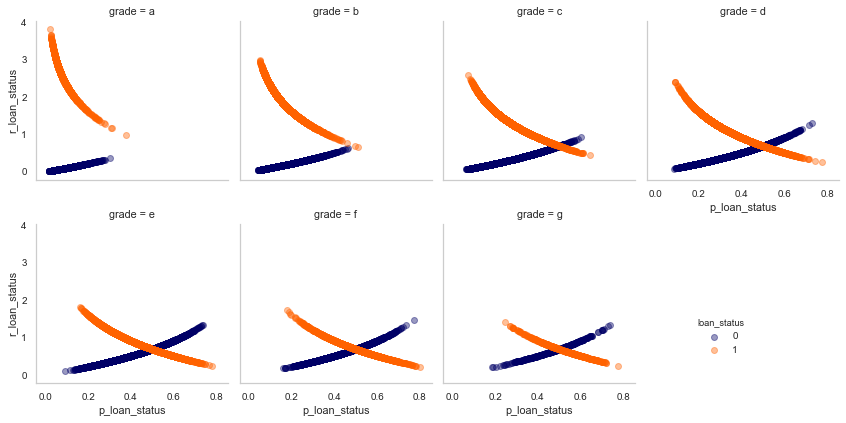

In [8]:
# use Seaborn FacetGrid for convenience
# some seaborn configs
import seaborn as sns
sns.set(font_scale=0.9)                                         # legible font size
sns.set_style('whitegrid', {'axes.grid': False})                # white background, no grid in plots
sns.set_palette(sns.color_palette(['#000066', '#FF6200']))            # consistent colors

# facet grid of residuals by PAY_0 
sorted_ = valid_yhat_df.sort_values(by='grade')                 # sort for better layout of by-groups
g = sns.FacetGrid(sorted_, col='grade', hue=target, col_wrap=4) # init grid
_ = g.map(plt.scatter, yhat_name, resid_name, alpha=0.4)        # plot points
_ = g.add_legend(bbox_to_anchor=(0.82, 0.2))                    # legend

### Model Performance across Categories


Creating segment wise ROC for : purpose


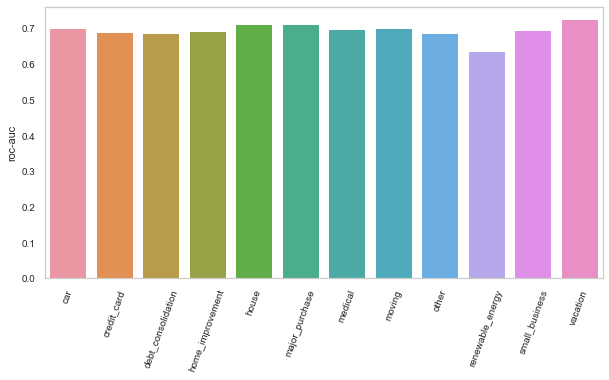

In [90]:
get_segment_rocauc(columns=['purpose'],model=mono_model,data_dict=data_dict)       

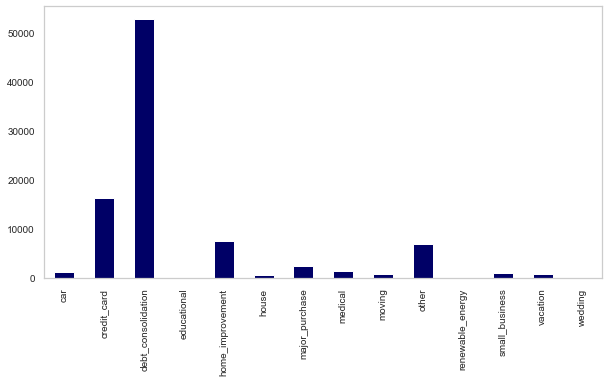

In [89]:
# Sort value counts of 'purpose'
data_dict['xtest']['purpose'].value_counts().sort_index().plot(kind='bar',figsize=(10,5))

### Residual Decision Tree

A simple decision tree can be built, to highlight the failure modes for the model.
We can futher simplfy it by choosing only the highly important features and creating a high cutoff for the residuals.

In [65]:
top5_feats = ['grade','dti','term','home_ownership','num_actv_bc_tl']
# Drop missing values
valid_yhat_df1 = valid_yhat_df1.dropna()
X_err = valid_yhat_df1[top5_feats]
y_err = valid_yhat_df1['r_loan_status'].apply(lambda x: 1 if x >= 2.5 else 0)
print(X_err.shape)

(25652, 5)


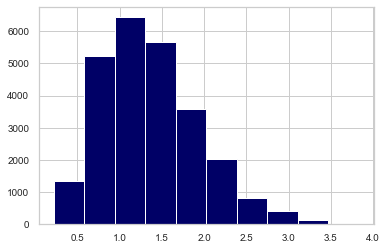

In [66]:
valid_yhat_df1['r_loan_status'].hist()

In [67]:

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold

X_ohe = pd.get_dummies(X_err)
clf =  DecisionTreeClassifier(max_depth=2,random_state=0)
mean_auc = cross_val_score(clf, X_ohe, y_err, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
                           scoring='roc_auc').mean()
print(f"AUC on residuals : {mean_auc}")
clf.fit(X_ohe,y_err)

AUC on residuals : 0.9719983624613621


DecisionTreeClassifier(max_depth=2, random_state=0)

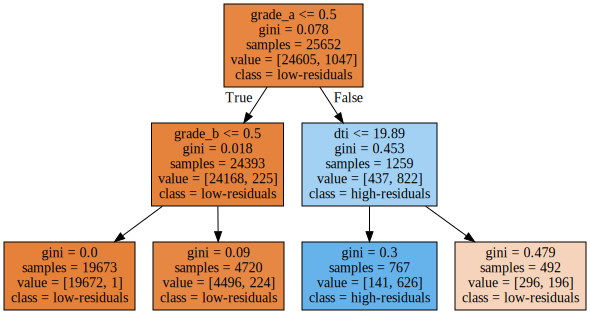

In [70]:
import graphviz
from sklearn import tree
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_ohe.columns,class_names=['low-residuals','high-residuals'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

/Users/ei08ob/Developer/anaconda3/envs/gdd3.6/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



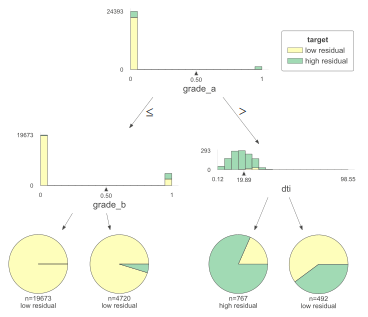

In [69]:
from dtreeviz.trees import dtreeviz # remember to load the package
viz = dtreeviz(clf, X_ohe, y,
                target_name="target",
                feature_names=X_ohe.columns,
                class_names=["low residual", "high residual"],)

viz